# **Computer Vision - Project**

**Automatic machine fault detection from Acoustic Data using Deep Learning**

**Group Members:**


*   **Hanzala Khalid  2021-SE-05**
*   **Ahtsham ul Haq  2021-SE-25**
*   **Abdullah Shahid 2021-SE-32**

## **Libraries**

In this phase/section, we installed and imported libraries that were necessary to run this project.

### **Installing Necessary Librarires**

In [1]:
# Installing necessary packages
!pip install gdown librosa tensorflow matplotlib scikit-learn opencv-python seaborn

### **Importing Necessary Libraries**

In [3]:
import os
import gdown
import zipfile
import shutil

In [10]:
import librosa
import numpy as np
import cv2

In [17]:
import matplotlib.pyplot as plt

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## **Mounting Google Drive**

In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Dataset**

First, we uploaded the given dataset to the Google Drive and from there, we load the dataset into the Colab environment.

In [4]:
# Google Drive file ID and URL
file_id = "1Oxbcp06EaSfctkHM--SGJQzHFfFO4nmG"
zip_filename = "fault_dataset.zip"
download_url = f"https://drive.google.com/uc?id={file_id}"


In [5]:
# Downloading the ZIP file
gdown.download(download_url, zip_filename, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1Oxbcp06EaSfctkHM--SGJQzHFfFO4nmG
From (redirected): https://drive.google.com/uc?id=1Oxbcp06EaSfctkHM--SGJQzHFfFO4nmG&confirm=t&uuid=41f3ca9c-fd68-477e-aa7e-cfc304e6d566
To: /content/fault_dataset.zip
100%|██████████| 48.0M/48.0M [00:00<00:00, 115MB/s]


'fault_dataset.zip'

Since the dataset was in zip format, we extracted it.

In [6]:
# Extracting the ZIP file into "fault_dataset" directory
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("fault_dataset")

After extracting the zip file, we defined the classes for the dataset.

In [7]:
# Organizing audio files into fault class folders
base_dir = "fault_dataset"
classes = ["Arcing", "Corona", "Looseness", "Tracking"]

After that we created separated folders for each class.

In [8]:
# Creating directories for each fault class if not present
for cls in classes:
    os.makedirs(os.path.join(base_dir, cls), exist_ok=True)

After the folder creation, we moved each of the audio file into their respective folders.

In [9]:
# Moving files to appropriate class folder based on filename keywords
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(('.wav', '.mp3', '.flac')):
            file_lower = file.lower()
            target_class = None
            for cls in classes:
                if cls.lower() in file_lower:
                    target_class = cls
                    break
            if target_class is not None:
                src_path = os.path.join(root, file)
                dst_path = os.path.join(base_dir, target_class, file)
                if not os.path.exists(dst_path):  # avoid duplicate moves
                    shutil.move(src_path, dst_path)


## **Processing**

In the next phase/section of this project, we segment the audio files into overlapping chunks (0.35 seconds with 20% overlap) and extracted features such as MFCC and STFT. After that each image is resized into a square (64×64) image.

In [11]:
# Parameters for segmentation and feature extraction
segment_duration = 0.35  # seconds per segment
overlap_percentage = 0.2  # 20% overlap
n_mfcc = 13
n_fft = 2048
hop_length = 512

Creating a function for extracting features

In [12]:
def extract_features(audio, sr):
    """
    Segmenting the audio and extracts MFCC, STFT magnitude (in dB), and phase features for each segment.
    Each feature matrix is resized to a common target shape (64x64) before stacking.
    """
    segment_length = int(segment_duration * sr)
    step = int(segment_length * (1 - overlap_percentage))
    segments = []

    # Segmenting the audio into overlapping chunks
    for start in range(0, len(audio) - segment_length + 1, step):
        segment = audio[start:start+segment_length]
        segments.append(segment)

    features = []
    target_shape = (64, 64)  # Common target shape for all features
    for segment in segments:
        # Computing MFCC
        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc)

        # Computing STFT and derive magnitude (in dB) and phase
        stft = librosa.stft(segment, n_fft=n_fft, hop_length=hop_length)
        magnitude = np.abs(stft)
        phase = np.angle(stft)
        magnitude_db = librosa.amplitude_to_db(magnitude, ref=np.max)

        # Resizing each feature matrix to the target shape
        mfcc_resized = cv2.resize(mfcc, target_shape)
        mag_resized = cv2.resize(magnitude_db, target_shape)
        phase_resized = cv2.resize(phase, target_shape)

        # Stacking the resized features along a new axis to create a 3-channel image
        stacked = np.stack([mfcc_resized, mag_resized, phase_resized], axis=-1)
        features.append(stacked)
    return features

## **Augmentation**

In this phase/section, we applied audio augmentation to each audio file by Time Stretching  (slightly faster and slower), Pitch shifting (up and down) and adding Slight Noise. After that eatures are then extracted from these augmented audio segments.

Creating a function for Data Augmentation

In [13]:
# Defining data augmentation function
def augment_audio(audio, sr):
    """Applying time stretching, pitch shifting, and noise addition to the input audio."""
    augmented_audios = []
    # Time stretching: faster and slower
    try:
        stretched_fast = librosa.effects.time_stretch(audio, rate=1.1)  # slightly faster
        augmented_audios.append(stretched_fast)
        stretched_slow = librosa.effects.time_stretch(audio, rate=0.9)  # slightly slower
        augmented_audios.append(stretched_slow)
    except Exception as e:
        print("Time stretching error:", e)
    # Pitch shifting: up and down (pass sr as a keyword argument)
    try:
        pitched_up = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=2)
        augmented_audios.append(pitched_up)
        pitched_down = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=-2)
        augmented_audios.append(pitched_down)
    except Exception as e:
        print("Pitch shifting error:", e)
    # Adding slight noise
    noise = np.random.normal(0, 0.005, size=audio.shape)
    noised_audio = audio + noise
    augmented_audios.append(noised_audio)
    return augmented_audios

## **Processing Audio Files and Extracting Features**

In this phase/section, we looped through each fault class directory, loaded the audio files, extracted features from both the original and augmented audio,
and then stored the features along with their labels.

In [14]:
# Processing audio files and extract features
data = []
labels = []

for cls in classes:
    class_dir = os.path.join(base_dir, cls)
    for file in os.listdir(class_dir):
        if file.lower().endswith(('.wav', '.mp3', '.flac')):
            file_path = os.path.join(class_dir, file)
            try:
                audio, sr = librosa.load(file_path, sr=None)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                continue
            # Extracting features from the original audio
            feats = extract_features(audio, sr)
            for feat in feats:
                data.append(feat)
                labels.append(cls)
            # Extracting features from augmented audio versions
            augmented_audios = augment_audio(audio, sr)
            for aug_audio in augmented_audios:
                feats_aug = extract_features(aug_audio, sr)
                for feat in feats_aug:
                    data.append(feat)
                    labels.append(cls)

In [15]:
# Converting lists to Numpy Arrays
data = np.array(data)
labels = np.array(labels)
print("Extracted features shape:", data.shape)

Extracted features shape: (12890, 64, 64, 3)


## **Image Conversion, Normalization & Saving**

Since our feature images are already resized to 64×64 in the extraction process, in this phase/section, we normalized them channel-wise.
We then saved each image (converted to a standard 0–255 scale) to Google Drive under a folder structure (`feature_images/<class>/`).
We also displayed 2–3 sample images from each class and print the total number of images generated per class.


### **Normalizing Images**

In [16]:
# Normalizing images channel-wise (zero mean and unit variance)
data_normalized = np.empty_like(data, dtype=np.float32)
for c in range(data.shape[-1]):
    channel = data[..., c]
    mean = np.mean(channel)
    std = np.std(channel) if np.std(channel) > 0 else 1.0
    data_normalized[..., c] = (channel - mean) / std

In [18]:
# Define the base directory for saving feature images in Google Drive
save_base_dir = '/content/drive/MyDrive/Computer Vision - Project/feature_images'
if not os.path.exists(save_base_dir):
    os.makedirs(save_base_dir)

### **Saving Images**

In [19]:
# Creating a Dictionary to store image count for each class
image_counts = {cls: 0 for cls in classes}

In [20]:
# Looping over each image and its label
for i, (img, label) in enumerate(zip(data_normalized, labels)):
    # Rescaling image to [0, 255] for saving
    img_min = img.min()
    img_max = img.max()
    img_scaled = (img - img_min) / (img_max - img_min + 1e-8)
    img_scaled = (img_scaled * 255).astype(np.uint8)

    # Ensuring the directory for the class exists
    class_dir = os.path.join(save_base_dir, label)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

    # Saving image using OpenCV (convert from RGB to BGR for cv2.imwrite)
    image_filename = os.path.join(class_dir, f"{label}_{image_counts[label]}.png")
    cv2.imwrite(image_filename, cv2.cvtColor(img_scaled, cv2.COLOR_RGB2BGR))
    image_counts[label] += 1

In [21]:
# Printing the total number of images for each class
print("Total number of pictures generated for each class:")
for cls in classes:
    print(f"{cls}: {image_counts[cls]}")

Total number of pictures generated for each class:
Arcing: 2512
Corona: 3119
Looseness: 3586
Tracking: 3673


### **Displaying Images**

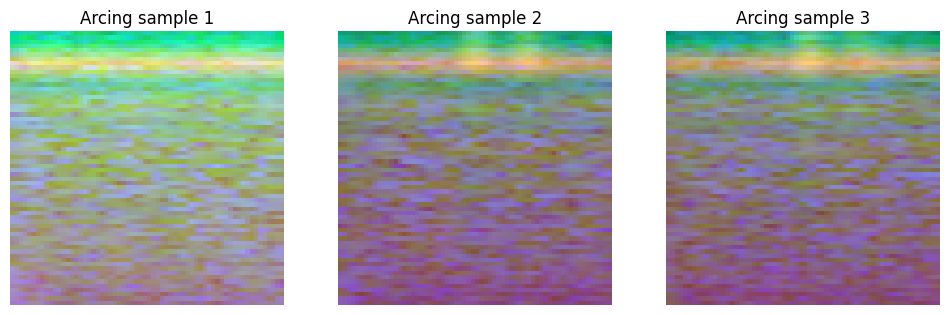

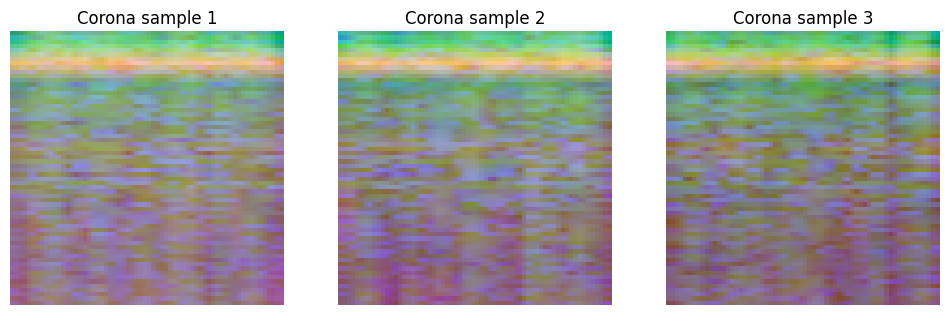

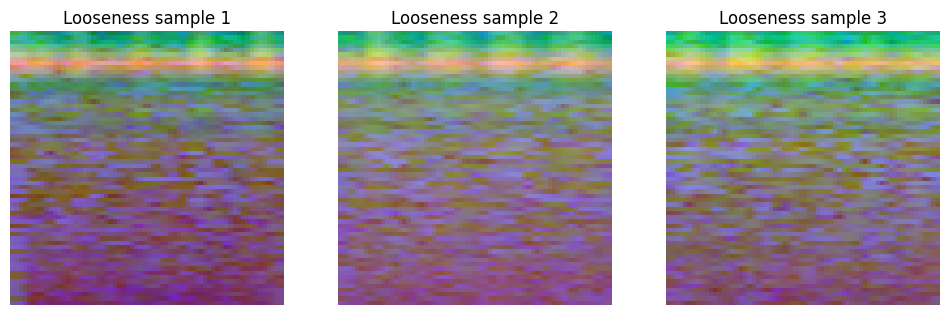

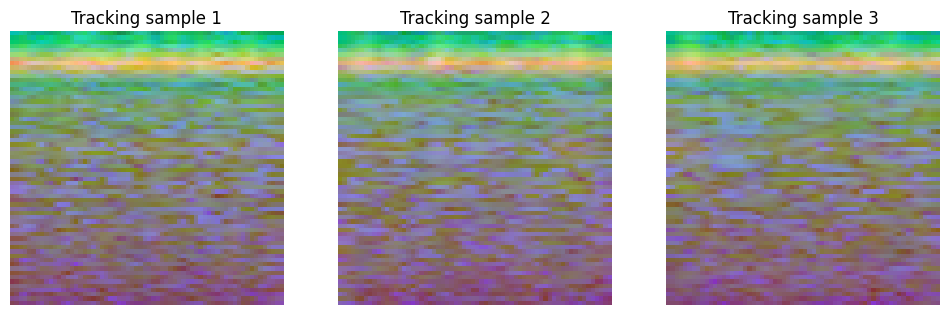

In [22]:
# Displaying 2-3 sample images from each class
for cls in classes:
    class_dir = os.path.join(save_base_dir, cls)
    images_list = os.listdir(class_dir)
    sample_images = images_list[:3]  # Taking the first 3 samples
    plt.figure(figsize=(12, 4))
    for j, img_file in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, j+1)
        plt.imshow(img)
        plt.title(f"{cls} sample {j+1}")
        plt.axis('off')
    plt.show()

## **Dataset**

In this phase/section, we encoded the fault class labels and split the dataset into training, validation, and test sets.


In [24]:
# Encoding labels as integers then converting them to one-hot vectors
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded, num_classes=len(classes))

In [25]:
# Splitting the dataset (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    data_normalized, labels_categorical, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [26]:
# Printing Datasets' Shapes
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (9023, 64, 64, 3)
Validation shape: (1933, 64, 64, 3)
Test shape: (1934, 64, 64, 3)


## **Model Building & Training**

In this phase/section, we build a Convolutional Neural Network (CNN) using TensorFlow/Keras. The network comprises:
- Convolutional layers
- Pooling layers
- Dropout for regularization
- Dense layers with a softmax output for the 4 fault classes

Early stopping is applied during training.



In [27]:
# Building and compiling the CNN model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [28]:
# shape of a single feature image
input_shape = X_train.shape[1:]

In [29]:
# Model Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,668 (6.20 MB)

 Trainable params: 1,625,668 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [44]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    #callbacks=[early_stop]
)

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8328 - loss: 0.4100 - val_accuracy: 0.8060 - val_loss: 0.4807
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8311 - loss: 0.4201 - val_accuracy: 0.8138 - val_loss: 0.4883
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8405 - loss: 0.3829 - val_accuracy: 0.8086 - val_loss: 0.4846
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8354 - loss: 0.4058 - val_accuracy: 0.8065 - val_loss: 0.5137
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8361 - loss: 0.3861 - val_accuracy: 0.8086 - val_loss: 0.5023
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8494 - loss: 0.3660 - val_accuracy: 0.8138 - val_loss: 0.4873
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8458 - loss: 0.3877 - val_accuracy: 0.8200 - val_loss: 0.4883
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8396 - loss: 0.3843 - val_accuracy: 0.

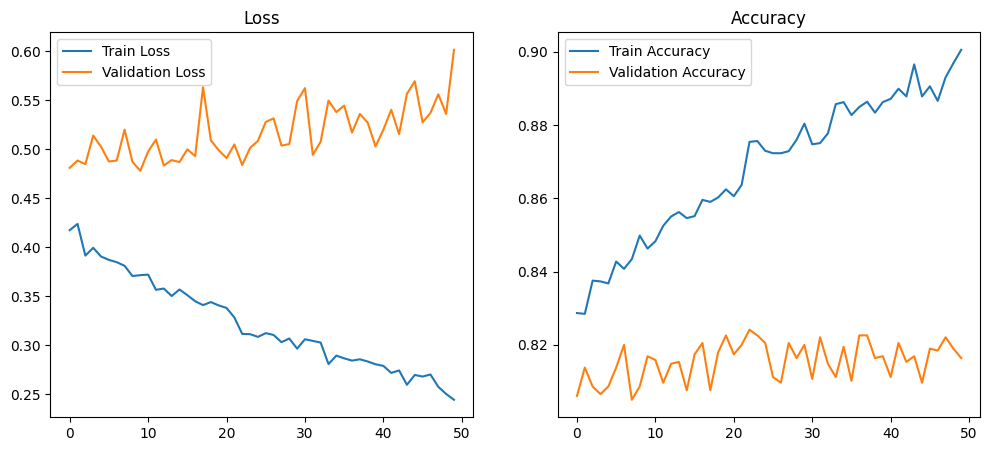

In [46]:
# Plotting training progress
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## **Evaluation**

In this phase/section, we evaluate the trained CNN model on the test dataset, created a confusion matrix, and then saved the trained model to Google Drive.

### **Model Evaluation**

In [47]:
# Evaluating the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8020 - loss: 0.6249
Test Accuracy: 0.8076525330543518


In [57]:
# Getting predicted labels for the test set
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


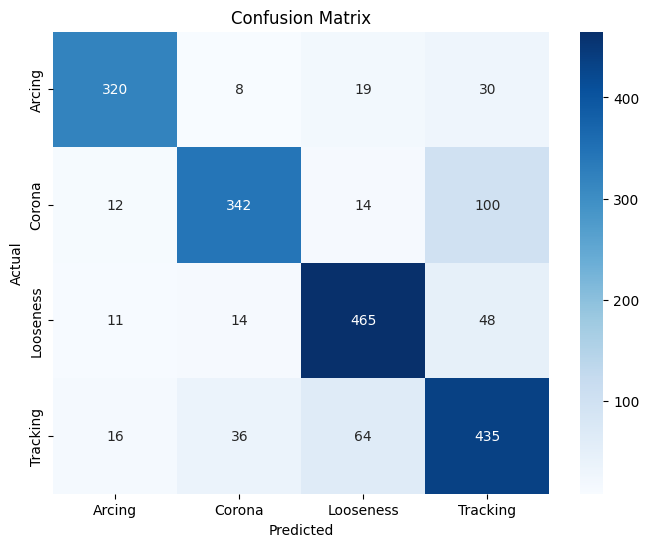

              precision    recall  f1-score   support

      Arcing       0.89      0.85      0.87       377
      Corona       0.85      0.73      0.79       468
   Looseness       0.83      0.86      0.85       538
    Tracking       0.71      0.79      0.75       551

    accuracy                           0.81      1934
   macro avg       0.82      0.81      0.81      1934
weighted avg       0.81      0.81      0.81      1934



In [58]:
# Plotting the Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()

# Printing the classification report
print(classification_report(y_true, y_pred, target_names=classes))

### **Saving the Model**

In [51]:
# Saving the trained model to Google Drive
model_save_path = '/content/drive/MyDrive/Computer Vision - Project/Saved Models/fault_detection_model_1.h5'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
model.save(model_save_path)
print("Model saved to:", model_save_path)

Model saved to: /content/drive/MyDrive/Computer Vision - Project/Saved Models/fault_detection_model_1.h5
